In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import re

In [2]:
data = pd.read_csv('../datasets/train_shortened.csv')
data.shape

(6079, 42)

In [3]:
# dropping all columns except question title, question, answer and ratings

cols = ['question_title', 'question_body', 'answer']
for i in data.columns[12:]:
    cols.append(i)
data = data[cols]

In [4]:
data.shape

(6079, 33)

# Text preprocessing

## Lowercasing and removing special characters

All special chars, except .?! are removed to keep clean text data. Stop, quetion mark and exclamation mark are kept, and will gain separate tokens, as end of sentence markers.

In [5]:
question_titles = data['question_title'].values.copy()
questions = data['question_body'].values.copy()
answers = data['answer'].values.copy()

In [6]:
def text_preprocessor(texts):

    # final list
    texts_prep = []
    # chars to remove from text
    filters =['\'', '\"', '$', '%' ,'&', '(', ')', '*', ',', '+', '-', '/',':',';','<','=','>'
              ,'[',']','^','_','`','{','|','}','~','\t','\n', '@', '\\']

    # cleaning whitespace: only one (' ') remains
    whitespace_cleaner = re.compile(r'\s+')
    for i in range(len(texts)):
        texts[i] = whitespace_cleaner.sub(' ', texts[i]).strip()

    # for each text
    for text in texts:
        # split it by whitespace
        split = text.split(' ')
        # list to save preprocessed text
        to_add = []
        # going word by word
        for word in split:
            proc = []
            # making list of valid words, removing urls
            if word.isascii() and word.startswith('http') == False:
                x = list(word)
                # going char by char
                for i in x:
                    # if char is not to be filtered out, keep it, else add whitespace instead of it
                    if i not in filters:
                        # if .?!, add whitespace to it, to keep it as separate token
                        if i == '?' or i == '.' or i == '!':
                            proc.append(' ' + i)
                        else:
                            proc.append(i)
                    else:
                        proc.append(' ')
                    if '' in proc:
                        proc.remove('')
                # apending word to to_add list, which contains its whole text
                to_add.append(''.join(proc).lower())
                    
        # apending list of words back to all texts list
        texts_prep.append(' '.join(to_add).strip())
        
    # cleaning whitespace again: only one (' ') remains
    whitespace_cleaner = re.compile(r'\s+')
    for i in range(len(texts_prep)):
        texts_prep[i] = whitespace_cleaner.sub(' ', texts_prep[i]).strip()
        
    return texts_prep

In [7]:
question_titles = text_preprocessor(question_titles)
questions = text_preprocessor(questions)
answers = text_preprocessor(answers)

In [8]:
# printing few answers before and after preprocessing

rdm = np.random.randint(0,len(answers), 5)

for i in rdm:
    print('ORIGINAL:   ', data.iloc[i]['answer'], '\n', 'PROCESSED:   ', answers[i], '\n\n\n')

ORIGINAL:    Not only can you, you have to. You never roll a &ldquo;Craft check&rdquo; or &ldquo;Perform check,&rdquo; those skills don&rsquo;t exist. Rather, they are categories of skills, like &ldquo;Craft (basketweaving)&rdquo; or &ldquo;Perform (underwater basketweaving).&rdquo; That&rsquo;s still true even if you have no ranks, and it&rsquo;s relevant for things like feats or instruments, which may need to be compatible with the chosen Craft or Perform skill.

Craft and Perform may be used without ranks, so if you have high Intelligence or high Charisma, and/or other bonuses to those skills, you could even be good at them without any training (e.g. ranks). It&rsquo;d be hard to keep up with someone who is actually training it, though.

Profession&rsquo;s much the same, but unless you are trained, you cannot roll the specific Profession skill at all (instead, you just get a flat 1 sp/day as unskilled labor). So having ranks in Profession (woven-basket critic) doesn&rsquo;t let you 

## Lemmatization

In [9]:
# POS tagging all words in tweets, and keeping tags only for nouns, verbs, adjectives and adverbs

def pos_tagger(texts):

    # procesed array-to-be
    texts_tagged = []

    for text in texts:
        # here each text is added after tagging
        tagged_final = []
        # splitting by whitespace and tagging
        split = text.split(' ')
        split = np.array(split)
        # some '' are stil left in list, cleaning them with numpy where
        where = np.where(split == '')
        split = np.delete(split, where)
        tagged = nltk.pos_tag(split)
        # keeping only tags for nouns, verbs, adjectives and adverbs
        for item in tagged:
            if item[1].startswith('N'):
                tagged_final.append((item[0],'n'))
            elif item[1].startswith('V'):
                tagged_final.append((item[0],'v'))
            elif item[1].startswith('J'):
                tagged_final.append((item[0],'a'))
            elif item[1].startswith('R'):
                tagged_final.append((item[0],'r'))
            else:
                tagged_final.append((item[0], None))
        # adding back to final list
        texts_tagged.append(tagged_final)
    
    return np.array(texts_tagged)

In [10]:
question_titles = pos_tagger(question_titles)
questions = pos_tagger(questions)
answers = pos_tagger(answers)

In [11]:
question_titles[0]

[('what', None),
 ('am', 'v'),
 ('i', 'a'),
 ('losing', 'n'),
 ('when', None),
 ('using', 'v'),
 ('extension', 'n'),
 ('tubes', 'n'),
 ('instead', 'r'),
 ('of', None),
 ('a', None),
 ('macro', 'n'),
 ('lens', 'n'),
 ('?', None)]

In [12]:
def lemmatize(texts):
    
    # using wordnet lemmatizer
    from nltk.stem import WordNetLemmatizer
    lem = WordNetLemmatizer()
    
    # lemmatized texts list to be
    texts_lemmed = []
    # going text by text, if word has valid tag (not None), lemmatize it
    for text in texts:
        to_add = []
        for i,j in text:
            if j == None:
                to_add.append(i)
            else:
                to_add.append(lem.lemmatize(i, pos = j))
        texts_lemmed.append(' '.join(to_add))
    
    return np.array(texts_lemmed)

In [13]:
question_titles = lemmatize(question_titles)
questions = lemmatize(questions)
answers = lemmatize(answers)

In [14]:
question_titles

array(['what be i losing when use extension tube instead of a macro lens ?',
       'what be the distinction between a city and a sprawl metroplex . . . between downtown and a commercial district ?',
       'maximum protusion length for through hole component pin', ...,
       'suppress file truncate message when use tail',
       'when should a supervisor be a co author ?',
       'why be there so many different type of screw phillps flat hex star etc ?'],
      dtype='<U140')

## Creating vocabulary

In [15]:
# stacking all texts together

all_texts = np.hstack((question_titles, questions, answers))

In [16]:
# seeing how many unique words there are

all_words = []

for i in all_texts:
    x = i.split(' ')
    for j in x:
        all_words.append(j)
        
len(all_words)

1741106

In [17]:
# number of unique words

len(list(set(all_words)))

44123

In [18]:
freq_dist = nltk.FreqDist(all_words)

In [19]:
len(freq_dist)

44123

In [20]:
# keeping only words which show up 10 or more times in tweets as tokens, discarding rest

tokens = {k:v for k,v in freq_dist.items() if v >= 10}

In [21]:
len(tokens)

8276

In [22]:
# fitting tokenizer on all texts
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words = 8277, filters = '')

tok.fit_on_texts(all_texts)

In [23]:
question_titles = tok.texts_to_sequences(question_titles)
questions = tok.texts_to_sequences(questions)
answers = tok.texts_to_sequences(answers)

In [24]:
# max len

max_len = []

for i in question_titles:
    max_len.append(len(i))
for i in questions:
    max_len.append(len(i))
for i in answers:
    max_len.append(len(i))
    
max(max_len)

887

In [25]:
pd.Series(max_len).describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99])

count    18237.000000
mean        90.573340
std        107.365434
min          0.000000
5%           5.000000
25%         12.000000
50%         55.000000
75%        126.000000
95%        310.000000
99%        512.000000
max        887.000000
dtype: float64

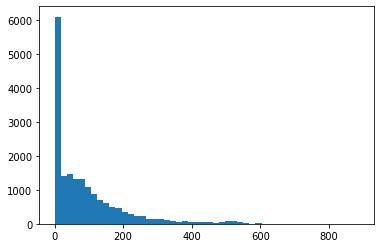

In [26]:
plt.hist(max_len, bins = 50)
plt.show()

In [27]:
# keeping max len of 500 tokens

question_titles = [i[:500] for i in question_titles]
questions = [i[:500] for i in questions]
answers = [i[:500] for i in answers]

In [28]:
# some texts are reduced to 0 words after tokenizing (dropping out all non token words)
# dropping them

to_drop = []

qt = []
for i in question_titles:
    qt.append(len(i))
qt = np.array(qt)
qt = np.where(qt<1)[0]
q = []
for i in questions:
    q.append(len(i))
q = np.array(q)
q = np.where(q<1)[0]
a = []
for i in answers:
    a.append(len(i))
a = np.array(a)
a = np.where(a<1)[0]

for i in qt:
    to_drop.append(i)
for i in q:
    to_drop.append(i)
for i in a:
    to_drop.append(i)
    
to_drop = np.unique(np.array(to_drop))
to_drop

array([1297, 2094, 2748])

In [29]:
# dropping data with those indices

df = pd.DataFrame()

df['question_titles'] = question_titles
df['questions'] = questions
df['answers'] = answers

In [30]:
df = df.drop(index = to_drop)
data = data.drop(index=to_drop)

In [31]:
# all to single dataframe and saving
data['question_titles'] = df['question_titles']
data['questions'] = df['questions']
data['answers'] = df['answers']

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6076 entries, 0 to 6078
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   question_title                         6076 non-null   object 
 1   question_body                          6076 non-null   object 
 2   answer                                 6076 non-null   object 
 3   question_asker_intent_understanding    6076 non-null   float64
 4   question_body_critical                 6076 non-null   float64
 5   question_conversational                6076 non-null   float64
 6   question_expect_short_answer           6076 non-null   float64
 7   question_fact_seeking                  6076 non-null   float64
 8   question_has_commonly_accepted_answer  6076 non-null   float64
 9   question_interestingness_others        6076 non-null   float64
 10  question_interestingness_self          6076 non-null   float64
 11  ques

In [108]:
data.to_pickle('../datasets/train_processed.pickle')

# Word2Vec embeddings

In [22]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [3]:
vecs = load_vectors('/home/ksaver/Desktop/wiki-news-300d-1M.vec')

In [4]:
type(vecs)

dict

In [27]:
# getting embeddings for our chosen tokens

w2v_embeddings = {}

for i in list(tokens.keys()):
    embedding = vecs.get(i)
    if embedding:
        w2v_embeddings[i] = list(embedding)
    else:
        pass

In [29]:
len(w2v_embeddings)

7227

In [30]:
len(tokens)

8276

In [32]:
# pickling embeddings
import pickle

with open('../datasets/w2v_embeddings.pickle', 'wb') as f:
    pickle.dump(w2v_embeddings, f)

In [23]:
# loading back embeddings
import pickle

with open('../datasets/w2v_embeddings.pickle', 'rb') as f:
    w2v_embeddings = pickle.load(f)

In [36]:
# converting texts into word2vec embeddings

def convert_w2v(inputs):
    
    padding = []

    for i in range(300):
        padding.append(0.)

    vec = []
    vec_final = []

    for i in inputs:
        embedded = []
        words = i.split(' ')
        for j in words:
            word = w2v_embeddings.get(j)
            if word:
                embedded.append(word)
        vec.append(embedded[:500])
        
    lens = []

    for i in vec:
        lens.append(len(i))

    max_len = max(lens)
    
    for i in vec:
        embedding = i.copy()
        for j in range(max_len-len(i)):
            embedding.append(padding)
        vec_final.append(np.array(embedding))
        
    return(np.array(vec_final, dtype = np.float16))
            

In [37]:
question_titles_vec = convert_w2v(question_titles)

In [38]:
question_titles_vec.shape

(6079, 32, 300)

In [41]:
questions_vec = convert_w2v(questions)

In [42]:
questions_vec.shape

(6079, 500, 300)

In [43]:
answers_vec = convert_w2v(answers)

In [44]:
answers_vec.shape

(6079, 500, 300)

In [45]:
to_drop = [1297, 2094, 2748]

In [46]:
question_titles_vec = np.delete(question_titles_vec, to_drop, axis = 0)
questions_vec = np.delete(questions_vec, to_drop, axis = 0)
answers_vec = np.delete(answers_vec, to_drop, axis = 0)

In [47]:
question_titles_vec.shape, questions_vec.shape, answers_vec.shape

((6076, 32, 300), (6076, 500, 300), (6076, 500, 300))

In [49]:
# pickling

with open('../datasets/question_titles_vec.pickle', 'wb') as f:
    pickle.dump(question_titles_vec, f)
    
with open('../datasets/questions_vec.pickle', 'wb') as f:
    pickle.dump(questions_vec, f)
    
with open('../datasets/answers_vec.pickle', 'wb') as f:
    pickle.dump(answers_vec, f)